In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

In [2]:
import accelerate
import peft
import bitsandbytes

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [120]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, PreTrainedModel, PretrainedConfig
from PIL import Image
import requests

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)

In [192]:
#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

In [196]:
print(model)

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

# inquire model inference

In [186]:
for name, param in model.encoder.named_parameters():
    print(f"{name}: {param.shape}")

embeddings.cls_token: torch.Size([1, 1, 384])
embeddings.distillation_token: torch.Size([1, 1, 384])
embeddings.position_embeddings: torch.Size([1, 578, 384])
embeddings.patch_embeddings.projection.weight: torch.Size([384, 3, 16, 16])
embeddings.patch_embeddings.projection.bias: torch.Size([384])
encoder.layer.0.attention.attention.query.weight: torch.Size([384, 384])
encoder.layer.0.attention.attention.query.bias: torch.Size([384])
encoder.layer.0.attention.attention.key.weight: torch.Size([384, 384])
encoder.layer.0.attention.attention.key.bias: torch.Size([384])
encoder.layer.0.attention.attention.value.weight: torch.Size([384, 384])
encoder.layer.0.attention.attention.value.bias: torch.Size([384])
encoder.layer.0.attention.output.dense.weight: torch.Size([384, 384])
encoder.layer.0.attention.output.dense.bias: torch.Size([384])
encoder.layer.0.intermediate.dense.weight: torch.Size([1536, 384])
encoder.layer.0.intermediate.dense.bias: torch.Size([1536])
encoder.layer.0.output.dense.

In [187]:
print(model.forward.__code__)

<code object forward at 0x000001EEB76256E0, file "d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\transformers\models\vision_encoder_decoder\modeling_vision_encoder_decoder.py", line 530>


In [194]:
def print_hook(module, input, output):
    print(f"Layer: {module.__class__.__name__}, Output shape: {output.shape if hasattr(output, 'shape') else type(output)}")

pixel_values=torch.randn(1, 3, 384, 384)
# Register hooks on all modules
for name, module in model.named_modules():
    module.register_forward_hook(print_hook)

In [195]:
# Run inference
with torch.no_grad():
    _ = model.generate(pixel_values)

Layer: Conv2d, Output shape: torch.Size([1, 384, 24, 24])
Layer: DeiTPatchEmbeddings, Output shape: torch.Size([1, 576, 384])
Layer: Dropout, Output shape: torch.Size([1, 578, 384])
Layer: DeiTEmbeddings, Output shape: torch.Size([1, 578, 384])
Layer: LayerNorm, Output shape: torch.Size([1, 578, 384])
Layer: Linear, Output shape: torch.Size([1, 578, 384])
Layer: Linear, Output shape: torch.Size([1, 578, 384])
Layer: Linear, Output shape: torch.Size([1, 578, 384])
Layer: DeiTSdpaSelfAttention, Output shape: <class 'tuple'>
Layer: Linear, Output shape: torch.Size([1, 578, 384])
Layer: Dropout, Output shape: torch.Size([1, 578, 384])
Layer: DeiTSelfOutput, Output shape: torch.Size([1, 578, 384])
Layer: DeiTSdpaAttention, Output shape: <class 'tuple'>
Layer: LayerNorm, Output shape: torch.Size([1, 578, 384])
Layer: Linear, Output shape: torch.Size([1, 578, 1536])
Layer: GELUActivation, Output shape: torch.Size([1, 578, 1536])
Layer: DeiTIntermediate, Output shape: torch.Size([1, 578, 1536]

In [197]:
import torch.fx
traced = torch.fx.symbolic_trace(model)
print(traced.graph)

TraceError: Proxy object cannot be iterated. This can be attempted when the Proxy is used in a loop or as a *args or **kwargs function argument. See the torch.fx docs on pytorch.org for a more detailed explanation of what types of control flow can be traced, and check out the Proxy docstring for help troubleshooting Proxy iteration errors

In [199]:
from torch.export import export

def forward(pixel_values):
    return model(pixel_values=pixel_values)

example_inputs = (pixel_values)
exported = export(forward, example_inputs)

ValueError: Expected `mod` to be an instance of `torch.nn.Module`, got <class 'function'>.

# applying encoder-decoder

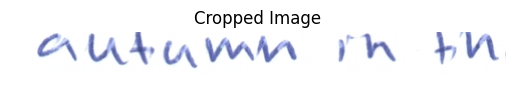

In [149]:
import pandas as pd
import cv2

# Select 10 random rows from the dataset
train_df_expanded = pd.read_csv('D:\\burtm\\Visual_studio_code\\PD_related_projects\\outputs\\preprocessed_data\\icdar_train_df_patches_20250515_164130.csv')
train_df_expanded.head()
i=102
train_df_expanded=train_df_expanded[train_df_expanded['isEng']==1]
train_df_expanded.reset_index(drop=True, inplace=True)
row = train_df_expanded.iloc[i]
image = cv2.imread(row['file_name'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Crop the section
cropped_image = image[row['y']+250:row['y2']-200, row['x']:row['x2']]

import matplotlib.pyplot as plt

plt.imshow(cropped_image)
plt.axis('off')
plt.title('Cropped Image')
plt.show()

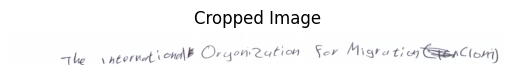

In [182]:
# Select 10 random rows from the dataset
train_df = pd.read_csv('D:\\burtm\\Visual_studio_code\\PD_related_projects\\outputs\\preprocessed_data\\icdar_train_df_20250514_175905.csv')
train_df.head()
i=15
train_df=train_df[train_df['isEng']==1]
train_df.reset_index(drop=True, inplace=True)
row = train_df.iloc[i]
image = cv2.imread(row['file_name'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Crop the section
full_image = image[1200:-2000, :]

plt.imshow(full_image)
plt.axis('off')
plt.title('Cropped Image')
plt.show()
#i=15 with 1700:1500 works fairly well

In [183]:
from PIL import Image
import numpy as np

# Convert cropped_image (numpy array) to PIL Image
typed=False
iam=False
full=True
if typed:
    typed_image = cv2.imread("d:\\burtm\\Visual_studio_code\\PD_related_projects\\typed sentence.png")
    #typed_image = cv2.imread("d:\\burtm\\Visual_studio_code\\PD_related_projects\\typed sentence.png")
    if typed_image is None:
        raise FileNotFoundError("The file 'typed sentence.png' was not found or could not be read. Please check the file path and ensure the image exists.")
    typed_image = cv2.cvtColor(typed_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(typed_image)
elif iam:
    typed_image = cv2.imread("d:\\burtm\\Visual_studio_code\\PD_related_projects\\iam_line.jpg")
    #typed_image = cv2.imread("d:\\burtm\\Visual_studio_code\\PD_related_projects\\typed sentence.png")
    if typed_image is None:
        raise FileNotFoundError("The file 'typed sentence.png' was not found or could not be read. Please check the file path and ensure the image exists.")
    typed_image = cv2.cvtColor(typed_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(typed_image)
    print("Cropped image shape:", typed_image.shape)
    print("Height:", typed_image.shape[0])
    print("Width:", typed_image.shape[1])
    print("Channels:", typed_image.shape[2])
elif full:
    print("Cropped image shape:", full_image.shape)
    print("Height:", full_image.shape[0])
    print("Width:", full_image.shape[1])
    print("Channels:", full_image.shape[2])
    pil_image = Image.fromarray(full_image)
else:
    print("Cropped image shape:", cropped_image.shape)
    print("Height:", cropped_image.shape[0])
    print("Width:", cropped_image.shape[1])
    print("Channels:", cropped_image.shape[2])
    pil_image = Image.fromarray(cropped_image)

# Preprocess the image
input = processor(images=pil_image, return_tensors="pt")

Cropped image shape: (165, 2483, 3)
Height: 165
Width: 2483
Channels: 3


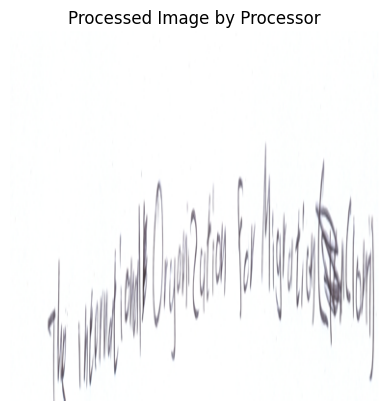

In [184]:
# Get the processed image tensor and convert it back to a numpy array for visualization
processed_img = input['pixel_values'][0].cpu().numpy()
# The image is in (C, H, W) format and normalized; convert to (H, W, C) and denormalize
processed_img = processed_img.transpose(1, 2, 0)
# Denormalize: processor uses mean=0.5, std=0.5, so reverse it
processed_img = (processed_img * 0.5 + 0.5) * 255
processed_img = processed_img.clip(0, 255).astype('uint8')

plt.imshow(processed_img)
plt.axis('off')
plt.title('Processed Image by Processor')
plt.show()

In [185]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
input = input.pixel_values.to(device) 

# Generate prediction
with torch.no_grad():
    generated_ids = model.generate(input)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Predicted text:", generated_text)

Predicted text: the unauthorized exaggeration for Migration


# testing encoder

In [ ]:
model=model.encoder()

In [ ]:
#dummy input
dummy_input=torch.randn(1, 3, 224, 224)
out = model()  # dummy input
loss = out.mean()
loss.backward()